# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Шаг 1. Откройте файлы с данными

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
hotel_train = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
hotel_test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')

In [4]:
display(hotel_train.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [5]:
display(hotel_test.head())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [6]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
id                                65229 non-null int64
is_canceled                       65229 non-null int64
lead_time                         65229 non-null float64
arrival_date_year                 65229 non-null int64
arrival_date_month                65229 non-null object
arrival_date_week_number          65229 non-null int64
arrival_date_day_of_month         65229 non-null int64
stays_in_weekend_nights           65229 non-null int64
stays_in_week_nights              65229 non-null int64
adults                            65229 non-null float64
children                          65229 non-null float64
babies                            65229 non-null float64
meal                              65229 non-null object
country                           65229 non-null object
distribution_channel              65229 non-null object
is_repeated_guest                 65229 non-null int64

In [7]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
id                                32412 non-null int64
is_canceled                       32412 non-null int64
lead_time                         32412 non-null float64
arrival_date_year                 32412 non-null int64
arrival_date_month                32412 non-null object
arrival_date_week_number          32412 non-null int64
arrival_date_day_of_month         32412 non-null int64
stays_in_weekend_nights           32412 non-null int64
stays_in_week_nights              32412 non-null int64
adults                            32412 non-null float64
children                          32412 non-null float64
babies                            32412 non-null float64
meal                              32412 non-null object
country                           32412 non-null object
distribution_channel              32412 non-null object
is_repeated_guest                 32412 non-null int64

In [8]:
#Объеденим данные для предварительной обработки в последующем разделим общий датасет на тестовую выборку и обучающую
merge_data = hotel_train.append(hotel_test)

In [9]:
#test_index = merge_data['id'].isin(hotel_test['id'])
#train_index = merge_data['id'].isin(hotel_train['id'])

In [10]:
#merge_data[train_index]
#merge_data[test_index]

### Шаг 2. Предобработка и исследовательский анализ данных

In [11]:
print('Колличество добликатов в датасете:',merge_data.duplicated().sum())

Колличество добликатов в датасете: 0


In [12]:
#Приведем значения в столбцах lead_time, adults, children, babies к типу int
merge_data[['lead_time','adults','children','babies']] = merge_data[['lead_time','adults','children','babies']].astype('int')

In [13]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97641 entries, 0 to 32411
Data columns (total 25 columns):
id                                97641 non-null int64
is_canceled                       97641 non-null int64
lead_time                         97641 non-null int64
arrival_date_year                 97641 non-null int64
arrival_date_month                97641 non-null object
arrival_date_week_number          97641 non-null int64
arrival_date_day_of_month         97641 non-null int64
stays_in_weekend_nights           97641 non-null int64
stays_in_week_nights              97641 non-null int64
adults                            97641 non-null int64
children                          97641 non-null int64
babies                            97641 non-null int64
meal                              97641 non-null object
country                           97641 non-null object
distribution_channel              97641 non-null object
is_repeated_guest                 97641 non-null int64
previou

In [14]:
merge_data.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000
mean,49050.280456,0.375201,96.752839,2016.144243,26.846581,15.784455,0.839361,2.263066,1.843887,0.077836,0.006667,0.028554,0.089972,0.128860,0.201729,2.314642,0.053195,0.560902,3.102426
std,28234.038292,0.484177,93.045823,0.706299,13.772847,8.754660,0.853682,1.362798,0.483393,0.337358,0.091790,0.166549,0.797737,1.530961,0.609830,15.224212,0.228000,0.783654,1.739882
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,24673.000000,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,49083.000000,0.000000,68.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,73493.000000,1.000000,152.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,374.000000,2017.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,72.000000,18.000000,259.000000,8.000000,5.000000,10.000000


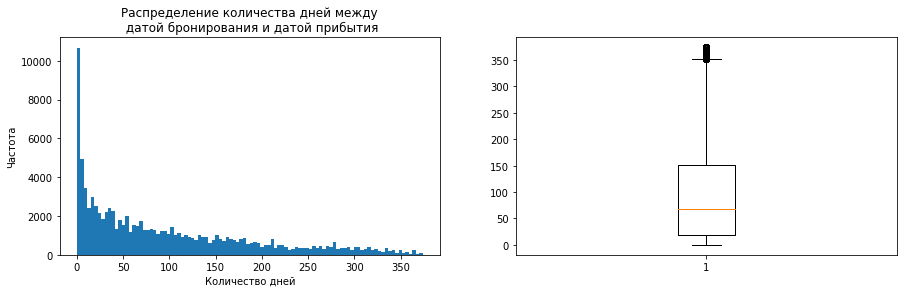

In [15]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].hist(merge_data['lead_time'], bins=100)
ax[0].set_title('Распределение количества дней между\n датой бронирования и датой прибытия')
ax[0].set_xlabel('Количество дней')
ax[0].set_ylabel('Частота')
ax[1].boxplot(merge_data['lead_time'], )
ax[1].set_title('')
plt.show()

In [16]:
# Доля заказов в которых значение количества дней между датой бронирования и датой прибытия превышает 350 дней
print('Доля дней > 350:',merge_data[merge_data['lead_time'] > 350]['id'].count() / merge_data.shape[0])

Доля дней > 350: 0.007722165893425917


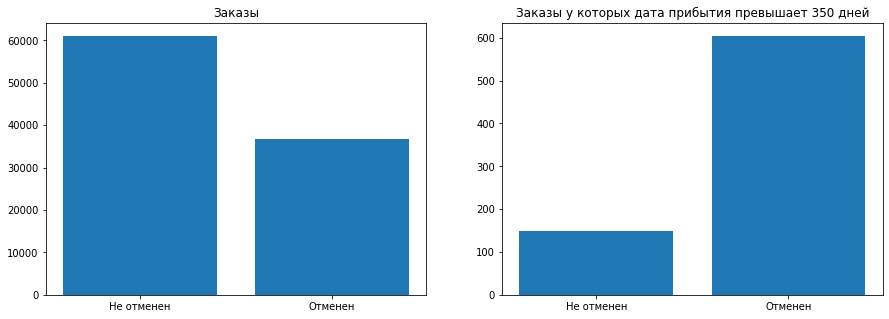

In [17]:
merge_is_canceled = merge_data.groupby('is_canceled').agg({'id':'count'}).reset_index()
merge_is_canceled_more_350_day = merge_data[merge_data['lead_time'] > 350].groupby('is_canceled').agg({'id':'count'}).reset_index()

f, ax = plt.subplots(1,2, figsize=(15, 5), sharex=True)
ax[0].set_title('Заказы')
ax[0].set_xticks(merge_is_canceled['is_canceled'])
ax[0].set_xticklabels(['Не отменен','Отменен'])
#ax[0].xlabel(merge_is_canceled['is_canceled'], labels=)
#ax[0].set_xticks(merge_is_canceled['is_canceled'], labels=['Не отменен','Отменен'])
ax[0].bar(data=merge_is_canceled, x='is_canceled', height='id')

ax[1].set_title('Заказы у которых дата прибытия превышает 350 дней')
#ax[1].set_xticks(merge_is_canceled_more_350_day['is_canceled'], labels=['Не отменен','Отменен'])
ax[1].bar(data=merge_is_canceled_more_350_day, x='is_canceled', height='id')
#plt.xtricks(merge_is_canceled['is_canceled'], labels=['Не отменен','Отменен'])
plt.show()


Ошибку поправил

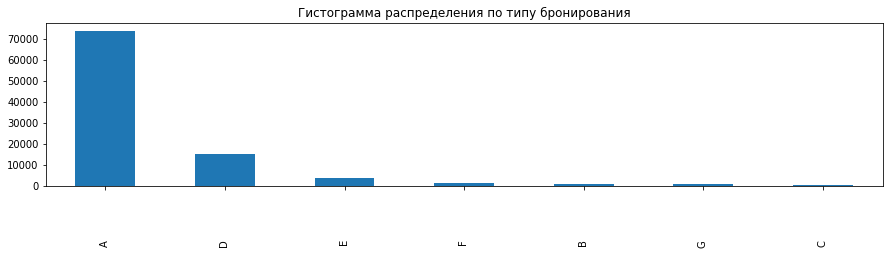

In [18]:
merge_data['reserved_room_type'].value_counts().plot(kind="bar", title="Гистограмма распределения по типу бронирования", figsize=(15,3))
plt.show()

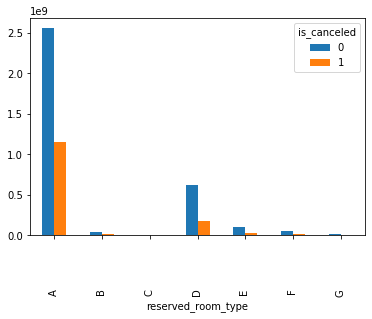

In [19]:
merge_data.groupby(['reserved_room_type', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar')

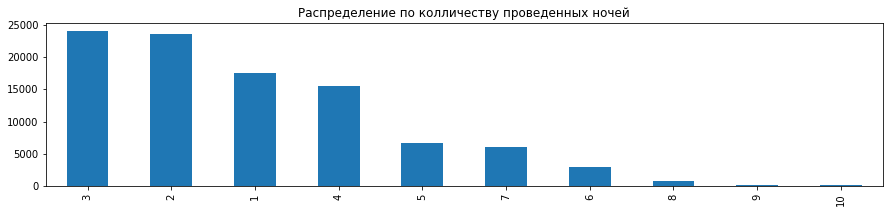

In [20]:
(
merge_data['total_nights'].value_counts().sort_values(ascending=False)
    .plot(kind='bar', title='Распределение по колличеству проведенных ночей', figsize=(15,3))
)
plt.show()

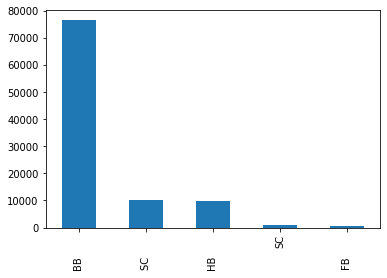

In [21]:
merge_data['meal'].value_counts().plot(kind='bar')

В значениях опции заказа присутствуют пробелы. Удалим их в значениях

In [22]:
merge_data['meal'] = merge_data['meal'].apply(lambda x: x.strip())

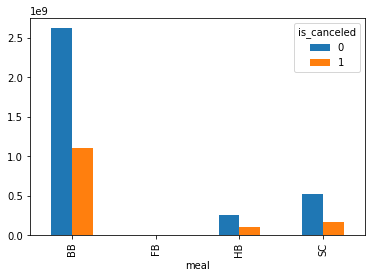

In [23]:
merge_data.groupby(['meal', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar')

В значениях стран присутсвуют невные дубликаты CH и CHN

In [24]:
merge_data['country'] = merge_data['country'].replace('CN', 'CHN')

In [25]:
merge_data['country'].value_counts()

PRT    38718
FRA     9451
GBR     9036
ESP     6832
DEU     6265
       ...  
MRT        1
ASM        1
ATF        1
BFA        1
NIC        1
Name: country, Length: 173, dtype: int64

In [26]:
country_values = merge_data['country'].value_counts().reset_index()
country_values['proportions'] = country_values['country'] / country_values['country'].sum()
country_values

,index,country,proportions
0,PRT,38718,0.396534
1,FRA,9451,0.096793
2,GBR,9036,0.092543
3,ESP,6832,0.069971
4,DEU,6265,0.064164
...,...,...,...
168,MRT,1,0.000010
169,ASM,1,0.000010
170,ATF,1,0.000010
171,BFA,1,0.000010


**Вывод:**
Очень много постояльцев из Португалии из остальных стран значительно меньше. Примем за пороговое значение долю в 1 процент. Все что меньше отнесем к категории Other.

In [27]:
#Отберем те страны из которых посетителей больше 1%
countries = country_values[country_values['country'] > 1000]

In [28]:
#Выберем названия стран
countries_value = list(countries['index'])

In [29]:
def set_country_other(value, countries):
    if value not in countries:
        return 'OTHER'
    
    return value

In [30]:
merge_data['country'] = merge_data['country'].apply(lambda x: set_country_other(x, countries_value))

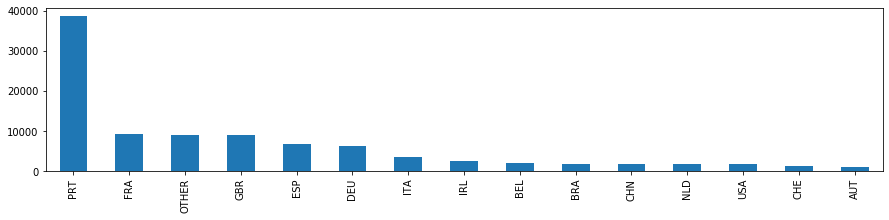

In [31]:
merge_data['country'].value_counts().plot(kind='bar', figsize=(15,3))

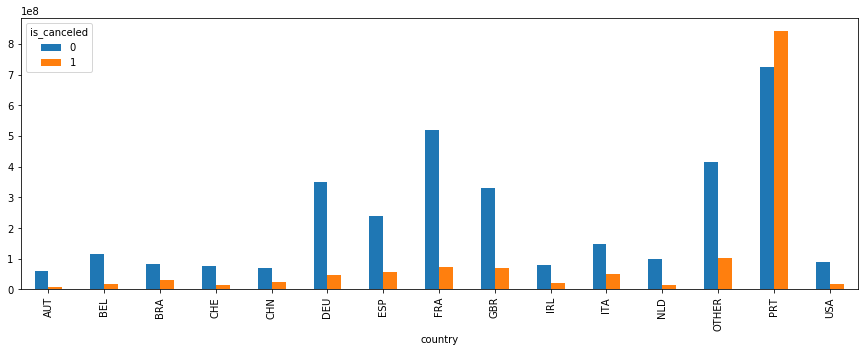

In [32]:
merge_data.groupby(['country', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar', figsize=(15,5))

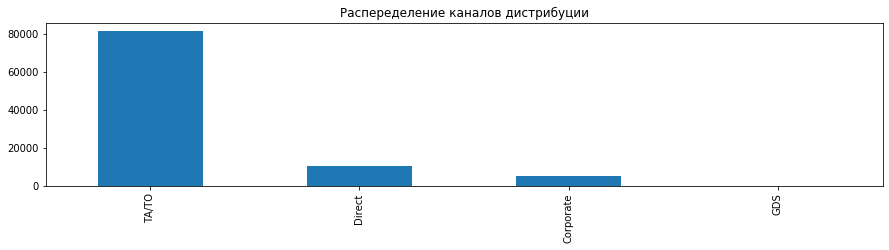

In [33]:
merge_data['distribution_channel'].value_counts().plot(kind='bar', figsize=(15,3), title='Распеределение каналов дистрибуции')
plt.show()

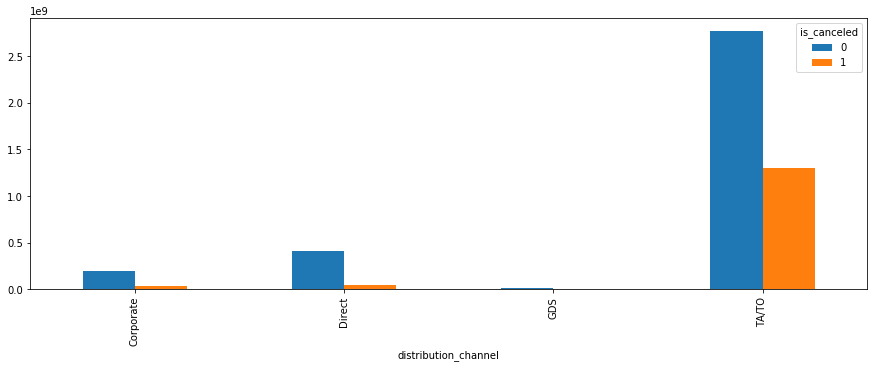

In [34]:
merge_data.groupby(['distribution_channel', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar', figsize=(15,5))

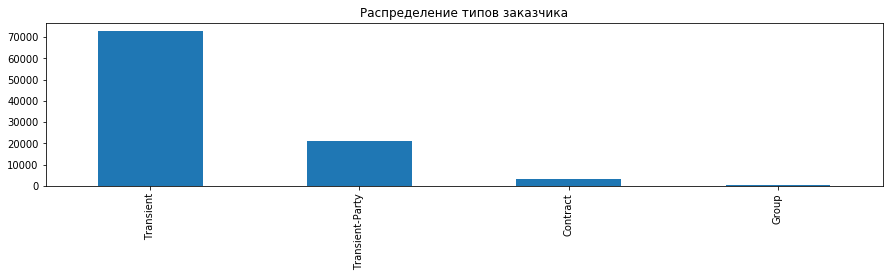

In [35]:
merge_data['customer_type'].value_counts().plot(kind='bar', figsize=(15,3), title='Распределение типов заказчика')
plt.show()

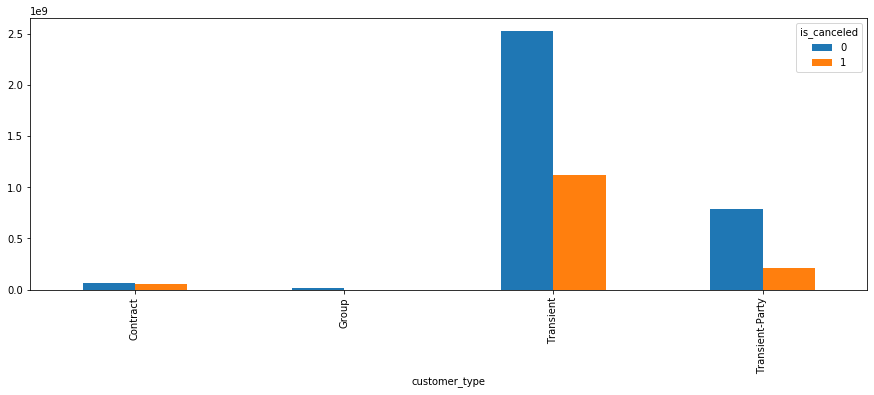

In [36]:
merge_data.groupby(['customer_type', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar', figsize=(15,5))

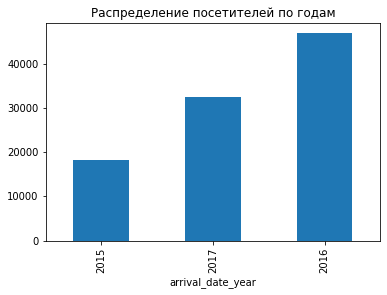

In [37]:
merge_data.groupby(['arrival_date_year'])['id'].agg('count').sort_values().plot(kind='bar', title="Распределение посетителей по годам")
plt.show()

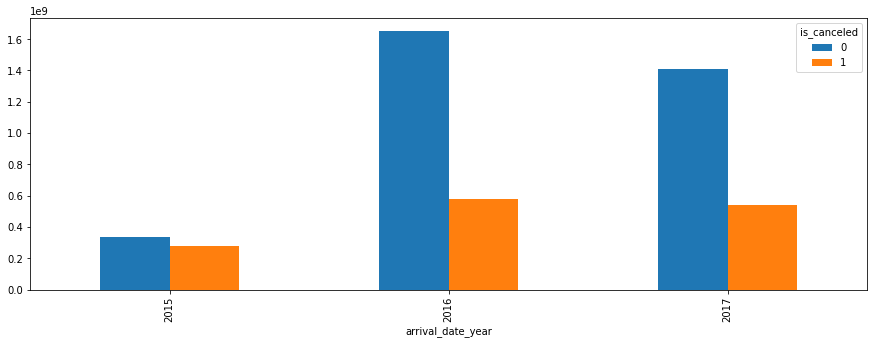

In [38]:
merge_data.groupby(['arrival_date_year', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar', figsize=(15,5))

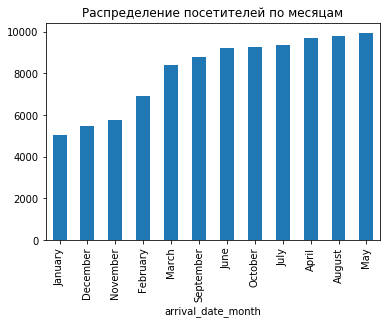

In [39]:
merge_data.groupby(['arrival_date_month'])['id'].agg('count').sort_values().plot(kind='bar', title="Распределение посетителей по месяцам")
plt.show()

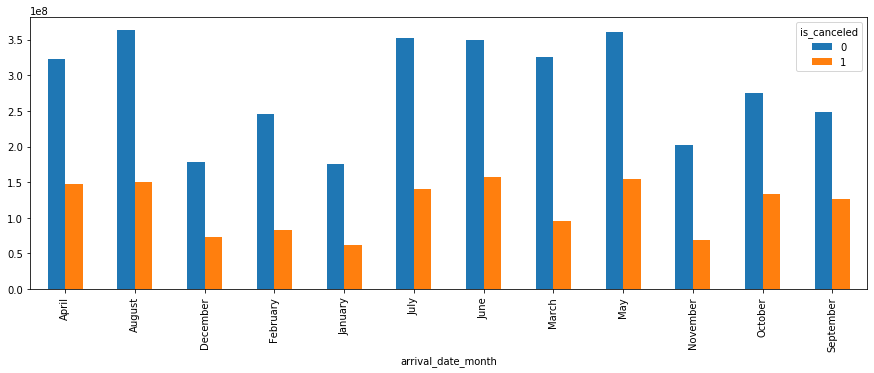

In [40]:
merge_data.groupby(['arrival_date_month', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar', figsize=(15,5))

**Вывод**

В зимнее время количество посетителей меньше чем в другое время

In [41]:
#Сгенерируем дополнительный категоральный признак время года
def get_season(value):
    if value in ['December', 'February', 'January']:
        return 'Winter'
    elif value in ['March', 'April', 'May']:
        return 'Spring'
    elif value in ['June', 'Jule', 'August']:
        return 'Summer'
    else:
        return 'Autumn'



In [42]:
merge_data['season'] = merge_data['arrival_date_month'].apply(lambda x: get_season(x))

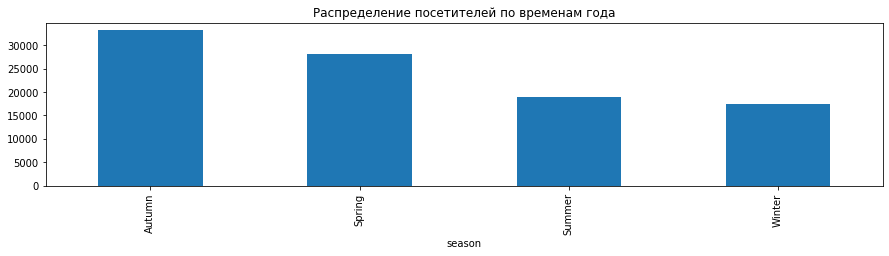

In [43]:
merge_data.groupby(['season'])['id'].agg('count').plot(kind='bar', figsize=(15,3), title="Распределение посетителей по временам года")
plt.show()

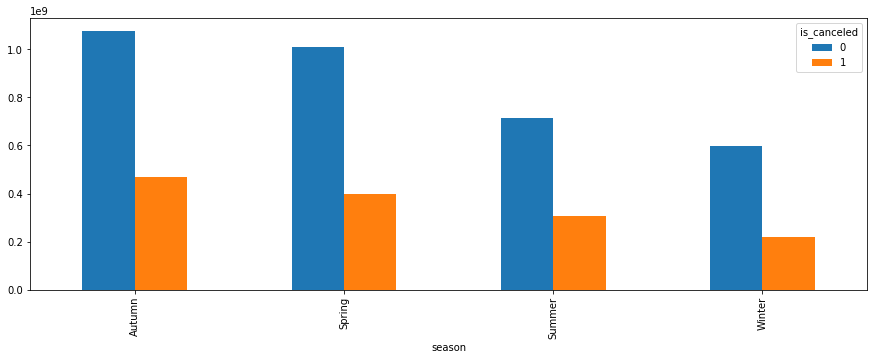

In [44]:
merge_data.groupby(['season', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar', figsize=(15,5))

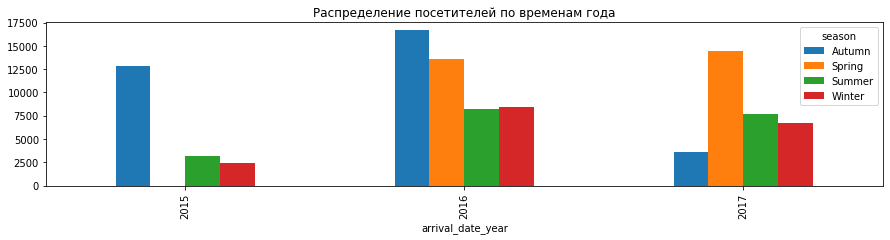

In [45]:
(merge_data.groupby(['arrival_date_year','season'])['id'].
        agg('count').
        unstack().
        plot(kind='bar',
        figsize=(15,3), title="Распределение посетителей по временам года")
)
plt.show()

In [46]:
merge_data['required_car_parking_spaces'].value_counts().sort_values()

8        2
3        2
2       17
1     5138
0    92482
Name: required_car_parking_spaces, dtype: int64

**Вывод**

Значения required_car_parking_spaces (необходимость места для автомобиля) содержит значения отличне от 0 и 1. Либо это информация о количестве требуемых мест, либо ошибка. Приведем все значения больше 1 к значению 1

In [47]:
merge_data['required_car_parking_spaces'] = merge_data['required_car_parking_spaces'].apply(lambda x: x == 1 if x > 1 else x)

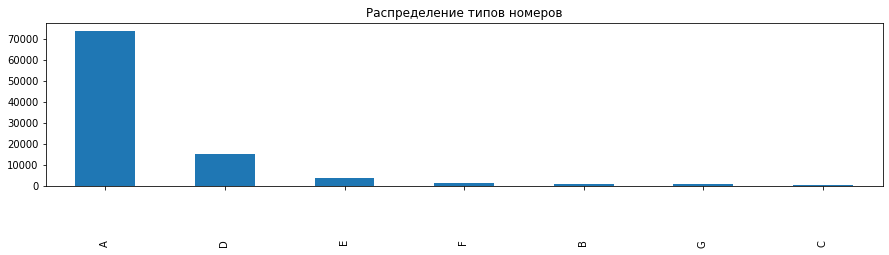

In [48]:
(
    merge_data['reserved_room_type'].value_counts().
    sort_values(ascending=False).
    plot(kind='bar', figsize=(15,3), 
         title="Распределение типов номеров")
)
plt.show()

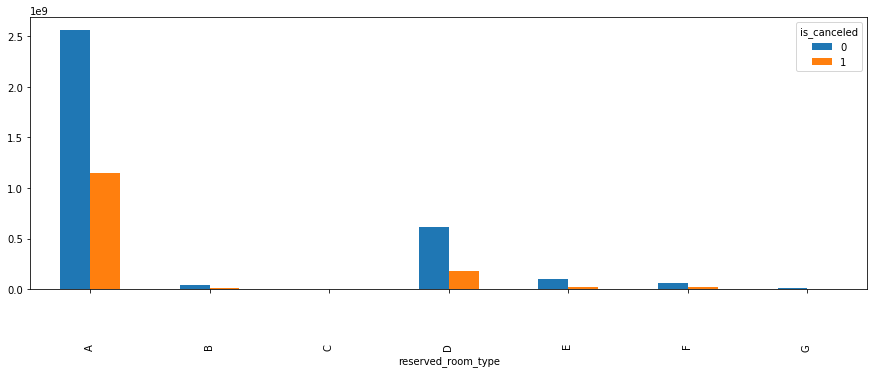

In [49]:
merge_data.groupby(['reserved_room_type', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar', figsize=(15,5))

In [50]:
merge_data['reserved_room_type'].value_counts().index

Index(['A               ', 'D               ', 'E               ',
       'F               ', 'B               ', 'G               ',
       'C               '],
      dtype='object')

In [51]:
#В названиях категорий присутствуют пробелы
merge_data['reserved_room_type'] = merge_data['reserved_room_type'].apply(lambda x: str.strip(x))

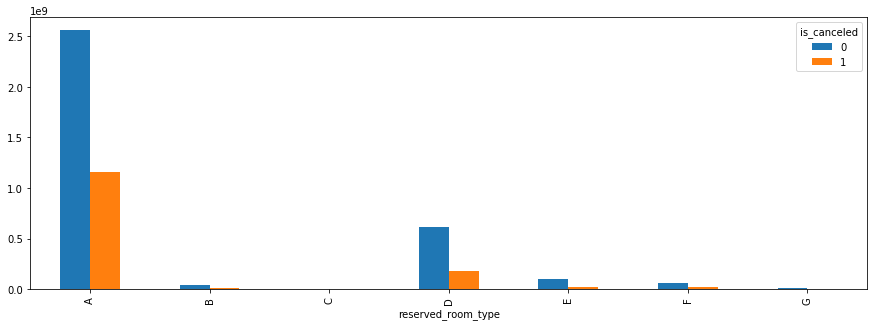

In [52]:
merge_data.groupby(['reserved_room_type', 'is_canceled'])['id'].agg('sum').unstack().plot(kind='bar', figsize=(15,5))

In [53]:
merge_data.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season
0,0,0,7,2015,July,27,1,0,1,1,...,0,0,A,0,0,Transient,0,0,1,Autumn
1,1,0,14,2015,July,27,1,0,2,2,...,0,0,A,0,0,Transient,0,1,2,Autumn
2,2,0,0,2015,July,27,1,0,2,2,...,0,0,C,0,0,Transient,0,0,2,Autumn
3,3,0,9,2015,July,27,1,0,2,2,...,0,0,C,0,0,Transient,0,1,2,Autumn
4,4,1,85,2015,July,27,1,0,3,2,...,0,0,A,0,0,Transient,0,1,3,Autumn


In [54]:
merge_data[['is_canceled', 'lead_time', 'adults', 
            'children', 'babies', 'is_repeated_guest', 
            'previous_cancellations', 'previous_bookings_not_canceled', 
            'booking_changes','days_in_waiting_list', 'required_car_parking_spaces',
            'total_of_special_requests', 'total_nights']].corr()

,is_canceled,lead_time,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,total_of_special_requests,total_nights
is_canceled,1.000000,0.299984,0.056370,-0.007118,-0.032091,-0.069861,0.119424,-0.052694,-0.140665,0.060559,-0.239981,0.013989
lead_time,0.299984,1.000000,0.139605,-0.021252,-0.017629,-0.114866,0.114428,-0.070645,0.006326,0.179106,-0.087274,0.204456
adults,0.056370,0.139605,1.000000,-0.003363,0.019303,-0.172597,-0.006787,-0.122792,-0.057814,-0.013161,0.154778,0.155435
children,-0.007118,-0.021252,-0.003363,1.000000,0.020284,-0.027708,-0.023967,-0.017159,0.049228,-0.033218,0.097475,0.039217
babies,-0.032091,-0.017629,0.019303,0.020284,1.000000,-0.008433,-0.007073,-0.005749,0.078981,-0.011043,0.087116,0.026057
is_repeated_guest,-0.069861,-0.114866,-0.172597,-0.027708,-0.008433,1.000000,0.101302,0.428689,0.011554,-0.023586,0.000016,-0.120718
previous_cancellations,0.119424,0.114428,-0.006787,-0.023967,-0.007073,0.101302,1.000000,0.174267,-0.028004,0.010679,-0.055219,-0.013746
previous_bookings_not_canceled,-0.052694,-0.070645,-0.122792,-0.017159,-0.005749,0.428689,0.174267,1.000000,0.014786,-0.009255,0.024882,-0.057777
booking_changes,-0.140665,0.006326,-0.057814,0.049228,0.078981,0.011554,-0.028004,0.014786,1.000000,-0.008155,0.050768,0.053770
days_in_waiting_list,0.060559,0.179106,-0.013161,-0.033218,-0.011043,-0.023586,0.010679,-0.009255,-0.008155,1.000000,-0.093692,-0.005266


Да, согласен. С корреляццией возникли проблемы, т.к. признаки категориальные и их очень много. Решил решать задачу не заостряя внимания на корреляцию. Да и времени не очень мого отсается.

### Шаг 3. Вычислите бизнес-метрику

In [55]:
'''
категория A: за ночь — 1 000, разовое обслуживание — 400;
категория B: за ночь — 800, разовое обслуживание — 350;
категория C: за ночь — 600, разовое обслуживание — 350;
категория D: за ночь — 550, разовое обслуживание — 150;
категория E: за ночь — 500, разовое обслуживание — 150;
категория F: за ночь — 450, разовое обслуживание — 150;
категория G: за ночь — 350, разовое обслуживание — 150.
В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
'''

def set_price(value):
    if value == 'A':
        return 1000
    elif value == 'B':
        return 800
    elif value == 'C':
        return 600
    elif value == 'D':
        return 550
    elif value == 'E':
        return 500
    elif value == 'F':
        return 450
    elif value == 'G':
        return 350

def set_price_service(value):
    if value == 'A':
        return 400
    elif value == 'B':
        return 350
    elif value == 'C':
        return 350
    elif value == 'D':
        return 150
    elif value == 'E':
        return 150
    elif value == 'F':
        return 150
    elif value == 'G':
        return 150

In [56]:
merge_data['price'] = merge_data['reserved_room_type'].apply(lambda x: set_price(x))
merge_data['price_service'] = merge_data['reserved_room_type'].apply(lambda x: set_price_service(x))

In [57]:
#В случае если клиент заказывает номер на долго то уборка 1 раз в 2 дня. 
#Посчитаем количество уборок.

def count_service(x):
    if x <= 2: 
        return 1
    else:
        return np.divmod(x, 2)[0]

In [58]:
merge_data['count_service'] = merge_data['total_nights'].apply(lambda x: count_service(x))

In [59]:
merge_data['count_service'].value_counts()

1    65189
2    22154
3     9154
4      971
5      173
Name: count_service, dtype: int64

In [60]:
def calc_season_price(x):
    if x['season'] in ['Spring', 'Autumn']:
        return x['price'] * 1.2
        #x['price_service'] = x['price_service'] * 1.2

    elif x['season'] == 'Summer':
        return x['price'] * 1.4
        #x['price_service'] = x['price_service'] * 1.4
    
def calc_season_price_service(x):
    if x['season'] in ['Spring', 'Autumn']:
        return x['price_service'] * 1.2
        #x['price_service'] = x['price_service'] * 1.2

    elif x['season'] == 'Summer':
        return x['price_service'] * 1.4
        #x['price_service'] = x['price_service'] * 1.4

In [61]:
#Внесем корректировки по сезонной стоимости
merge_data['price'] = merge_data[['price', 'season']].apply(lambda x: calc_season_price(x), axis=1)

In [62]:
merge_data['price_service'] = merge_data[['price_service', 'season']].apply(lambda x: calc_season_price_service(x), axis=1)

In [63]:
# Функция расчета дохода 
def calc_income(x):
    if x['is_canceled'] == 1:
        return 0
    else:
        return x['total_nights'] * x['price'] - x['price_service'] * x['count_service']

Да, здесь я просто не то посчитал

In [64]:
#Расчитаем доход кот клиентов без внедрения демозитов
merge_data['income'] = merge_data.apply(lambda x: calc_income(x), axis=1)

In [65]:
print("Доход полученный за все время без внедрения депозитов {0:.2f} млн.".format(merge_data['income'].sum() / 1000000))

Доход полученный за все время без внедрения депозитов 136.34 млн.


In [66]:
(merge_data['price'].sum() / 1000000), merge_data['income'].sum() / 1000000, merge_data['price_service'].sum() / 1000000

(88.72807, 136.34209, 34.1666)

В функции уже учитываеются отказники, если отказ, то доход по такой

In [67]:
merge_data

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season,price,price_service,count_service,income
0,0,0,7,2015,July,27,1,0,1,1,...,0,Transient,0,0,1,Autumn,1200.0,480.0,1,720.0
1,1,0,14,2015,July,27,1,0,2,2,...,0,Transient,0,1,2,Autumn,1200.0,480.0,1,1920.0
2,2,0,0,2015,July,27,1,0,2,2,...,0,Transient,0,0,2,Autumn,720.0,420.0,1,1020.0
3,3,0,9,2015,July,27,1,0,2,2,...,0,Transient,0,1,2,Autumn,720.0,420.0,1,1020.0
4,4,1,85,2015,July,27,1,0,3,2,...,0,Transient,0,1,3,Autumn,1200.0,480.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,August,35,31,2,4,2,...,0,Transient,0,0,6,Summer,1400.0,560.0,3,6720.0
32408,97900,0,21,2017,August,35,30,2,5,2,...,0,Transient,0,2,7,Summer,1400.0,560.0,3,8120.0
32409,97901,0,23,2017,August,35,30,2,5,2,...,0,Transient,0,0,7,Summer,1400.0,560.0,3,8120.0
32410,97902,0,34,2017,August,35,31,2,5,2,...,0,Transient,0,4,7,Summer,770.0,210.0,3,4760.0


In [68]:
def calc_deposit(x):
    if x['is_canceled'] == 1:
        return (x['price'] + x['price_service']) * 0.8
    else:
        return 0
    

In [69]:
#Расчитаем размер депозита для тех клиентов, которые отказались от заказа
merge_data['deposit'] = merge_data.apply(lambda x: calc_deposit(x), axis=1)

In [70]:
width_deposite_income = (merge_data['deposit'].sum() + merge_data['income'].sum()) / 1000000
print("Доход полученный за все время c внедрением депозитов {0:.2f} млн.".format(width_deposite_income))

Доход полученный за все время c внедрением депозитов 175.08 млн.


**Вывод**

С внедрением депозитов, доход отеля может вырасти со 136 млн. до 175 млн.

Вероятно такие суммы, т.к. я считаю по всем данным.

### Шаг. 4 Разработка модели ML

In [71]:
#Определим по каким данным будем расчитывать модель
"""
data = merge_data[['id','is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']]
"""
data = merge_data[['id','is_canceled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'days_in_waiting_list',
       'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_nights']]

Согласен по поводу дат, а id позже удаляется.. оно мне понадобится что бы разделить весь датасет на обучающую выборку и тестовую.

In [72]:
data.head()

,id,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7,0,1,1,0,0,BB,GBR,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14,0,2,2,0,0,BB,GBR,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0,0,2,2,0,0,BB,PRT,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9,0,2,2,0,0,FB,PRT,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85,0,3,2,0,0,BB,PRT,...,0,0,0,A,0,0,Transient,0,1,3


In [73]:
encoder = OrdinalEncoder() 
data_encoder = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

In [74]:
data_encoder.head()

,id,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0.0,0.0,7.0,0.0,1.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,1.0,0.0,14.0,0.0,2.0,2.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
2,2.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0
3,3.0,0.0,9.0,0.0,2.0,2.0,0.0,0.0,1.0,13.0,...,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0
4,4.0,1.0,85.0,0.0,3.0,2.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0


В обучении было сказано, что метод fit самотоятельно определяет категориальные признаки

In [75]:
#Преобразуем наши данные обратно обучающей выборке и к тестовой
test_index = data_encoder['id'].isin(hotel_test['id'])
train_index = data_encoder['id'].isin(hotel_train['id'])

train = data_encoder[train_index].copy().reset_index(drop=True)
test = data_encoder[test_index].copy().reset_index(drop=True)

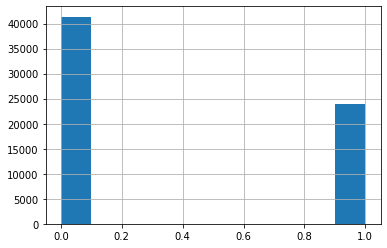

In [76]:
train['is_canceled'].hist()

In [77]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [78]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [79]:
features_train = train.drop(['is_canceled', 'id'], axis=1)
target_train = train['is_canceled']

features_test = test.drop(['is_canceled', 'id'], axis=1)
target_test = test['is_canceled']

In [80]:
features_train.head(3)

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,7.0,0.0,1.0,1.0,0.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
1,14.0,0.0,2.0,2.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
2,0.0,0.0,2.0,2.0,0.0,0.0,0.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0


In [81]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

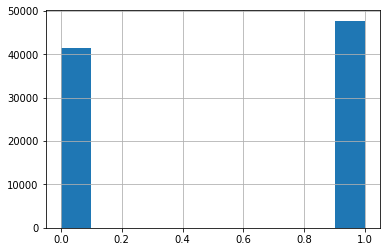

In [82]:
target_upsampled.hist()

In [83]:
#Шастабировать признаки
scaler = StandardScaler()
scaler.fit(features_upsampled)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [84]:
features_train_scaled = scaler.transform(features_upsampled)
features_test_scaled = scaler.transform(features_test)

In [85]:
model = LogisticRegression(solver='lbfgs',class_weight='balanced' , random_state=12345)
model.fit(features_train_scaled, target_upsampled)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
predict_test = model.predict(features_test_scaled)

In [87]:
print(classification_report(target_test, predict_test))

              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77     19444
         1.0       0.65      0.65      0.65     12705

    accuracy                           0.72     32149
   macro avg       0.71      0.71      0.71     32149
weighted avg       0.72      0.72      0.72     32149



In [88]:
print("AUC_ROC:", roc_auc_score(target_test, predict_test))

AUC_ROC: 0.7113541296528336


In [89]:
#Проверим модель на адекватность 
target_pred_constant = pd.Series(target_test, copy=True)
target_pred_constant.iloc[:] = 0

print(classification_report(target_test, target_pred_constant))

              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75     19444
         1.0       0.00      0.00      0.00     12705

    accuracy                           0.60     32149
   macro avg       0.30      0.50      0.38     32149
weighted avg       0.37      0.60      0.46     32149



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Логистическая регрессия показывает лучшие результаты чем простая модель.

In [90]:
model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=10) 
model.fit(features_train_scaled, target_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [91]:
predict_test = model.predict(features_test_scaled)
print('Accuracy:', accuracy_score(target_test, predict_test))
print('F1 Score:', f1_score(target_test, predict_test))

Accuracy: 0.7609256897570686
F1 Score: 0.6921659724447292


In [92]:
print(classification_report(target_test, predict_test))

              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80     19444
         1.0       0.70      0.68      0.69     12705

    accuracy                           0.76     32149
   macro avg       0.75      0.75      0.75     32149
weighted avg       0.76      0.76      0.76     32149



In [93]:

probabilities_valid = model.predict_proba(features_test_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print("AUC_ROC:", auc_roc)

AUC_ROC: 0.8408575296023633


Наиболее лучший результат показал случайный лес:

- Accuracy: 0.76
- F1 Score: 0.69
- AUC_ROC: 0.84

In [94]:
#Оценим модель кросс-валидацией
scores = cross_val_score(model, features_test_scaled, target_test, cv=10)
final_score = pd.Series(scores).mean()

print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.7497303294531109


In [95]:
test_index = merge_data['id'].isin(hotel_test['id'])
test = merge_data[test_index].copy().reset_index(drop=True)

In [96]:
print("Доход полученный по тестовому датасету без внедрения депозитов {0:.2f} млн.".format(test['income'].sum() / 1000000))

Доход полученный по тестовому датасету без внедрения депозитов 43.60 млн.


In [97]:
width_deposite_income = (test['deposit'].sum() + test['income'].sum()) / 1000000
print("Доход, который мог быть получен по тестовому датасету с внедрением депозитов {0:.2f} млн.".format(width_deposite_income))

Доход, который мог быть получен по тестовому датасету с внедрением депозитов 56.38 млн.


In [98]:
predict = pd.DataFrame(predict_test)

In [99]:
pred_test = test.iloc[predict[predict[0] == 1].index]
width_deposite_income_pred = (pred_test['deposit'].sum() + pred_test['income'].sum()) / 1000000
print("Доход, который мог быть получен по тестовому датасету с внедрением депозитов по предсказанным данным {0:.2f} млн.".format(width_deposite_income_pred))

Доход, который мог быть получен по тестовому датасету с внедрением депозитов по предсказанным данным 17.16 млн.


In [100]:
pred_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,season,price,price_service,count_service,income,deposit
5,6091,1,52,2017,January,1,1,2,5,1,...,Transient,0,0,7,Winter,NaN,NaN,3,0.0,NaN
6,6092,1,143,2017,January,1,2,1,1,2,...,Transient,0,1,2,Winter,NaN,NaN,1,0.0,NaN
31,6118,1,23,2017,January,1,7,2,1,2,...,Transient,0,1,3,Winter,NaN,NaN,1,0.0,NaN
40,6127,1,1,2017,January,2,11,0,1,1,...,Transient,0,0,1,Winter,NaN,NaN,1,0.0,NaN
53,6140,1,33,2017,January,2,14,2,1,2,...,Transient,0,0,3,Winter,NaN,NaN,1,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32126,97618,0,3,2017,August,35,27,1,0,1,...,Transient,0,1,1,Summer,1400.0,560.0,1,840.0,0.0
32130,97622,0,301,2017,August,35,27,2,0,2,...,Transient,0,0,2,Summer,630.0,210.0,1,1050.0,0.0
32131,97623,0,234,2017,August,34,26,2,1,2,...,Transient,1,0,3,Summer,1120.0,490.0,1,2870.0,0.0
32140,97632,0,219,2017,August,34,25,2,2,2,...,Transient,0,1,4,Summer,1400.0,560.0,2,4480.0,0.0


### Шаг 5. Выявите признаки «ненадёжного» клиента

In [101]:
#importances = model.feature_importances_

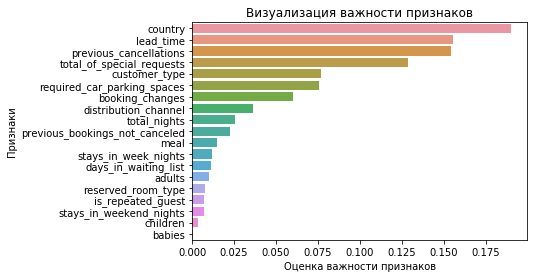

In [102]:

def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_train.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    ax.set_title('Визуализация важности признаков')

chart_feature_imp(model)

Сорян.. вроде все работало... поправил)

- Заказы у которых дата прибытия превышает 350 дней вероятнее всего будут отменены
- Для категории номеров A и D больше всего отказов 
- Для заказов с опцией включен завтрак, больше всего отказов
- Больше всего отмен из Португалии

In [103]:
count = merge_data[merge_data['arrival_date_year'] == 2017].groupby('arrival_date_month')['id'].agg('count').mean()

In [104]:
print(f'Среднее колличество бронироваинй за месяц за последний год', count) 

Среднее колличество бронироваинй за месяц за последний год 4051.5


In [105]:
canceled = ( merge_data[(merge_data['is_canceled'] == 1) & (merge_data['arrival_date_year'] == 2017)].
     groupby(['arrival_date_year','arrival_date_month'])['id'].agg('count').mean()
)

In [106]:
print(f'Среднее количество отказов в месяц за последний год', canceled)

Среднее количество отказов в месяц за последний год 1573.875


In [107]:
income = merge_data[merge_data['arrival_date_year'] == 2017].groupby('arrival_date_month')['income'].agg('sum').mean()

In [108]:
print(f'Средний доход в месяц за последний год', income / 1000000, 'млн.')

Средний доход в месяц за последний год 5.450035 млн.


In [109]:
deposit = merge_data[merge_data['arrival_date_year'] == 2017].groupby('arrival_date_month')['deposit'].agg('sum').mean()

In [110]:
print(f'Средний доход от внедрения депозита в месяц за последний год', deposit / 1000000, 'млн.' )

Средний доход от внедрения депозита в месяц за последний год 1.597623 млн.


### Шаг 6. Напишите общий вывод

- Разработанная модель позволяет с 75% точностью определить клиента который откажется от брони.
- С внедрением депозитов, доход отеля мог бы вырасти за весь период с 136 млн. до 175млн
- Общий доход по тестовым данным без внедрения депозитов составил 43.6 млн. При внедрении депозитов и применением модели машинного обучения доход бы мог вырасти на 17 млн. При условии что на разработку модели было бы затрачено 400 т.р. эта сумма бы окупилась за год.

- депозит 80% я посчитал за один день проживания и 1 раза обслуживания 
- нашел ошибку.. числа уменьшились. Получается что в среднем доход от внедрения депозита в среднем в месяц увеличится на 1,6 млн. что уже влияет на окупаемость.

#### Вопрос от себя )
 - наверно нужно использовать бутстрап? тема оказалась очень сложная для меня, хотя и понятная в целом. Нужно руку набивать. Времени жаль мало.. работу поменял. Успеваю делать только поздно вечером.